**Steps**

> Indented block


            i.) importing important dependdicies.
            ii)creating the U-net model
            iii) defining weights and biases
            iv)importing data frrom kaggle into colab
            v)unziping the data
            vi)creating generator for importing images at the time of run,(dont save all the data to memory)
            vii)  creating forward loop
            viii)defining cost function
            ix) creating optimizer
            x)  creating session 
            xii) running model
            xiii) evaluating output

In [1]:
# loading requried package
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import array_to_img ,img_to_array ,ImageDataGenerator ,load_img
from scipy.misc import imresize
from subprocess import check_output
from sklearn.model_selection import train_test_split
from IPython.display import Image
from google.colab import files

Using TensorFlow backend.


 **U-Net  Model**
    

*   Convolution neural network used for segmentation of images.
*   First part of the network consist convolution and max-pooling.


> Indented block




    > activation function  =relu ,filter size =3*3 with zero padding.
         two convoultion followed by max_pooling



*   Second part of the network consist of convolution and unpooling.
*   cost function: pixel-wise category cross_entropy or log_loss summed over all the images.


*   output feature in U-net model have less spatial dimension that those of the input.
*  **note:** for pixel to pixel class comparision for loss computation-> segmented output feature maps are compared to a ground truth segmented image of patch size 388*388 extracted from the cener of the input images.


*   Model archtecture given below: 









      

In [2]:
uploaded = files.upload() # for uploading file directly from pc to colab

Saving U_net_arch.png to U_net_arch.png


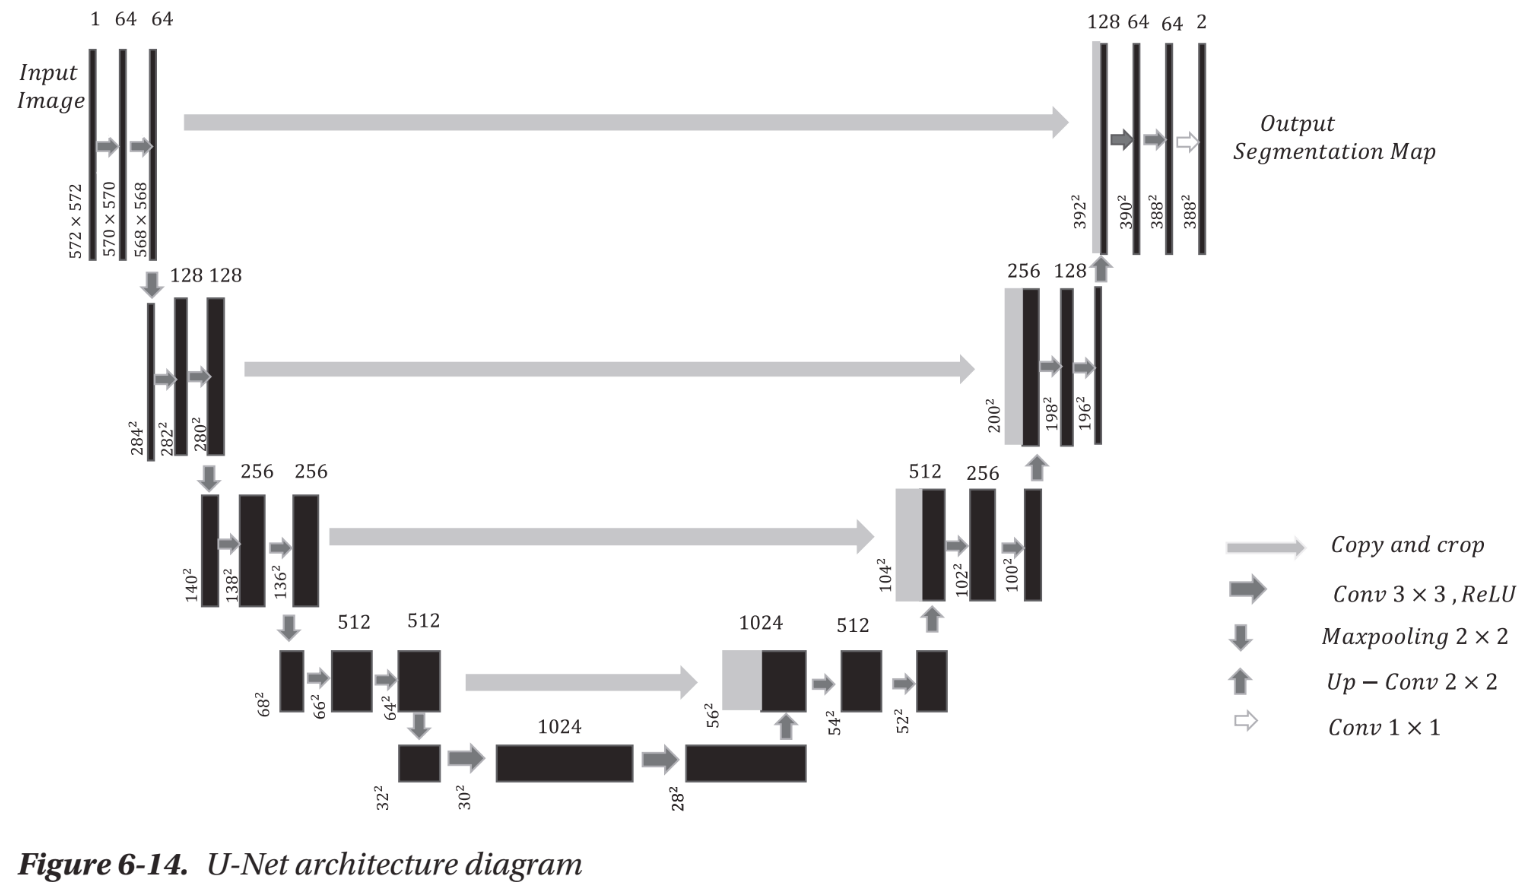

In [3]:
Image('U_net_arch.png')

In [0]:
# define downsampling - 2 ->(conv+relu) + 1->maxpool
#maxpooling can be set to false when needed
x = tf.placeholder(tf.float32 ,[None ,128 ,128,3])
y = tf.placeholder(tf.float32 ,[None,128 ,128 ,1])
def down_sample(x ,w1 ,b1 ,w2,b2 ,pool ='True'):
  x = tf.nn.conv2d(x ,w1 ,strides =[1,1,1,1] ,padding ='SAME')
  x = tf.nn.bias_add(x ,b1)
  x = tf.nn.conv2d(x ,w2 ,strides =[1,1,1,1] ,padding ='SAME')
  x = tf.nn.bias_add(x ,b2)
  x = tf.nn.relu(x)
  if pool:
    y = tf.nn.max_pool(x ,ksize =[1,2,2,1] ,strides =[1,2,2,1] ,padding ='SAME')
    return y ,x
  else:
    return x
##########################################3
# define upsampling 
def up_sample(x ,w,b): 
  output_shape = x.get_shape().as_list()    # give output as list of (None ,input_width ,input_height, input_channel)
  output_shape[0]  = 32                     # first element of output should be  batch size
  output_shape[1] *= 2                     # width gets doubled
  output_shape[2] *= 2                     # height gets doubled
  output_shape[3] = w.get_shape().as_list()[2] # ouput depth should be equal to the no of channel of filters
  conv_tf = tf.nn.conv2d_transpose(value =x ,filter =w ,output_shape =output_shape ,strides =[1,2,2,1] ,padding ='SAME')
  conv_tf = tf.nn.bias_add(conv_tf ,b)
  conv_tf = tf.nn.relu(conv_tf)
  return conv_tf


In [0]:
# defining weights and biases
weights = {'w11':tf.Variable(tf.random_normal([3,3,3,64],mean =0.0 ,stddev =0.02)) ,
          'w12':tf.Variable(tf.random_normal([3,3,64,64],mean =0.0 ,stddev =0.02)),
          'w21':tf.Variable(tf.random_normal([3,3,64,128],mean =0.0 ,stddev =0.02)) ,
          'w22':tf.Variable(tf.random_normal([3,3,128,128],mean =0.0 ,stddev =0.02)) ,
          'w31':tf.Variable(tf.random_normal([3,3,128,256],mean =0.0 ,stddev =0.02)) ,
          'w32':tf.Variable(tf.random_normal([3,3,256,256],mean =0.0 ,stddev =0.02)) ,
          'w41':tf.Variable(tf.random_normal([3,3,256,512],mean =0.0 ,stddev =0.02)) ,
          'w42':tf.Variable(tf.random_normal([3,3,512,512],mean =0.0 ,stddev =0.02)) ,
          'w51':tf.Variable(tf.random_normal([3,3,512,1024],mean =0.0 ,stddev =0.02)),
          'w52':tf.Variable(tf.random_normal([3,3,1024,1024],mean =0.0 ,stddev =0.02)) ,
          'wu1':tf.Variable(tf.random_normal([3,3,1024,1024],mean =0.0 ,stddev =0.02)), 
          'wu2':tf.Variable(tf.random_normal([3,3,512,1024],mean =0.0 ,stddev =0.02)) ,
          'wu3':tf.Variable(tf.random_normal([3,3,256,512],mean =0.0 ,stddev =0.02)) ,
          'wu4':tf.Variable(tf.random_normal([3,3,128,256],mean =0.0 ,stddev =0.02)) ,
          'wf':tf.Variable(tf.random_normal([1,1,128,1],mean =0.0 ,stddev =0.02))}
biases = {'b11':tf.Variable(tf.random_normal([64],mean =0.0 ,stddev =0.02)) ,
          'b12':tf.Variable(tf.random_normal([64],mean =0.0 ,stddev =0.02)),
          'b21':tf.Variable(tf.random_normal([128],mean =0.0 ,stddev =0.02)) ,
          'b22':tf.Variable(tf.random_normal([128],mean =0.0 ,stddev =0.02)) ,
          'b31':tf.Variable(tf.random_normal([256],mean =0.0 ,stddev =0.02)) ,
          'b32':tf.Variable(tf.random_normal([256],mean =0.0 ,stddev =0.02)) ,
          'b41':tf.Variable(tf.random_normal([512],mean =0.0 ,stddev =0.02)) ,
          'b42':tf.Variable(tf.random_normal([512],mean =0.0 ,stddev =0.02)) ,
          'b51':tf.Variable(tf.random_normal([1024],mean =0.0 ,stddev =0.02)),
          'b52':tf.Variable(tf.random_normal([1024],mean =0.0 ,stddev =0.02)) ,
          'bu1':tf.Variable(tf.random_normal([1024],mean =0.0 ,stddev =0.02)), 
          'bu2':tf.Variable(tf.random_normal([512],mean =0.0 ,stddev =0.02)) ,
          'bu3':tf.Variable(tf.random_normal([256],mean =0.0 ,stddev =0.02)) ,
          'bu4':tf.Variable(tf.random_normal([128],mean =0.0 ,stddev =0.02)) ,
          'bf':tf.Variable(tf.random_normal([1],mean =0.0 ,stddev =0.02))}

In [0]:
######## creating  model
def unet(x ,weights ,biases ,dropout =1):
  ###### first half of network -> downsample of images
  out1 ,res1 = down_sample(x ,weights['w11'],biases['b11'] ,weights['w12'] ,biases['b12'] ,pool =True) # stroing resolution of images which we will use during upsampling
  out1 ,res1 = down_sample(out1 ,weights['w21'] ,biases['b21'] ,weights['w22'] ,biases['b22'] ,pool =True)
  out1 ,res1 = down_sample(out1 ,weights['w31'] ,biases['b31'] ,weights['w32'] ,biases['b32'] ,pool =True)
  out1 ,res1 = down_sample(out1 ,weights['w41'] ,biases['b41'] ,weights['w42'] ,biases['b42'] ,pool =True)
  out1 = down_sample(out1 ,weights['w51'] ,biases['b51'] ,weights['w52'] ,biases['b52'] ,pool =False)
  #####################################################################
  ####### 2nd half of the network -> up-sampling
  up1 = up_sample(out1 ,weights['wu1'] ,biases['bu1'])
  up1 = up_sample(up1 ,weights['wu2'] ,biases['bu2'] )
  up1 = up_sample(up1 ,weights['wu3'] ,biases['bu3'] )
  up1 = up_sample(up1 ,weights['wu4'] ,biases['bu4'] )
  out =tf.nn.conv2d(up1 ,weights['wf'] ,strides =[1,1,1,1] ,padding ='SAME')
  out = tf.nn.bias_add(out, biases['bf'])
  return out


In [7]:
# installing dependencoes for uploading dataset directly from kaggle
!pip install kaggle
!pip install imageio

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 235kB 5.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
    100% |████████████████████████████████| 3.3MB 5.4MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [8]:
# upload kaggle credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajiv10","key":"ca75a4d118774772fb6c8e38068220bf"}'}

In [9]:
# checking if its here
ls -1ha kaggle.json

kaggle.json


In [0]:
# file configuaration
!mkdir -p ~/.kaggle                            # storing into kaggle directory
!cp kaggle.json ~/.kaggle/                     # copying the file into the above directory
  
!chmod 600 ~/.kaggle/kaggle.json               # command line that give permission in linux

In [11]:
# downloading the datasets
!kaggle competitions download -c carvana-image-masking-challenge

  0% 0.00/81.2k [00:00<?, ?B/s]
100% 81.2k/81.2k [00:00<00:00, 37.4MB/s]
 96% 28.0M/29.1M [00:00<00:00, 29.7MB/s]
100% 29.1M/29.1M [00:00<00:00, 87.4MB/s]
 96% 18.0M/18.8M [00:00<00:00, 45.7MB/s]
100% 18.8M/18.8M [00:00<00:00, 78.2MB/s]
  0% 0.00/225k [00:00<?, ?B/s]
100% 225k/225k [00:00<00:00, 151MB/s]
 99% 401M/405M [00:03<00:00, 106MB/s]
100% 405M/405M [00:03<00:00, 122MB/s]
100% 7.75G/7.76G [01:21<00:00, 62.8MB/s]
100% 7.76G/7.76G [01:21<00:00, 102MB/s] 
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 80.3MB/s]
 99% 795M/804M [00:08<00:00, 109MB/s] 
100% 804M/804M [00:08<00:00, 101MB/s]
100% 15.4G/15.4G [02:44<00:00, 111MB/s]
100% 15.4G/15.4G [02:44<00:00, 101MB/s]


In [12]:
# unzip
!ls

29bb3ece3180_11.jpg  sample_submission.csv.zip	train_masks.csv.zip
kaggle.json	     test_hq.zip		train_masks.zip
metadata.csv.zip     test.zip			train.zip
sample_data	     train_hq.zip		U_net_arch.png


In [13]:
# unzipping the train data
!unzip train.zip

Archive:  train.zip
   creating: train/
  inflating: train/00087a6bd4dc_01.jpg  
  inflating: train/00087a6bd4dc_02.jpg  
  inflating: train/00087a6bd4dc_03.jpg  
  inflating: train/00087a6bd4dc_04.jpg  
  inflating: train/00087a6bd4dc_05.jpg  
  inflating: train/00087a6bd4dc_06.jpg  
  inflating: train/00087a6bd4dc_07.jpg  
  inflating: train/00087a6bd4dc_08.jpg  
  inflating: train/00087a6bd4dc_09.jpg  
  inflating: train/00087a6bd4dc_10.jpg  
  inflating: train/00087a6bd4dc_11.jpg  
  inflating: train/00087a6bd4dc_12.jpg  
  inflating: train/00087a6bd4dc_13.jpg  
  inflating: train/00087a6bd4dc_14.jpg  
  inflating: train/00087a6bd4dc_15.jpg  
  inflating: train/00087a6bd4dc_16.jpg  
  inflating: train/02159e548029_01.jpg  
  inflating: train/02159e548029_02.jpg  
  inflating: train/02159e548029_03.jpg  
  inflating: train/02159e548029_04.jpg  
  inflating: train/02159e548029_05.jpg  
  inflating: train/02159e548029_06.jpg  
  inflating: train/02159e548029_07.jpg  
  inflating: trai

In [14]:
# unzipping the train_mask
!unzip train_masks.zip

Archive:  train_masks.zip
   creating: train_masks/
  inflating: train_masks/00087a6bd4dc_01_mask.gif  
 extracting: train_masks/00087a6bd4dc_02_mask.gif  
 extracting: train_masks/00087a6bd4dc_03_mask.gif  
 extracting: train_masks/00087a6bd4dc_04_mask.gif  
  inflating: train_masks/00087a6bd4dc_05_mask.gif  
  inflating: train_masks/00087a6bd4dc_06_mask.gif  
  inflating: train_masks/00087a6bd4dc_07_mask.gif  
  inflating: train_masks/00087a6bd4dc_08_mask.gif  
  inflating: train_masks/00087a6bd4dc_09_mask.gif  
  inflating: train_masks/00087a6bd4dc_10_mask.gif  
 extracting: train_masks/00087a6bd4dc_11_mask.gif  
  inflating: train_masks/00087a6bd4dc_12_mask.gif  
  inflating: train_masks/00087a6bd4dc_13_mask.gif  
  inflating: train_masks/00087a6bd4dc_14_mask.gif  
 extracting: train_masks/00087a6bd4dc_15_mask.gif  
 extracting: train_masks/00087a6bd4dc_16_mask.gif  
  inflating: train_masks/02159e548029_01_mask.gif  
 extracting: train_masks/02159e548029_02_mask.gif  
 extracting:

In [15]:
!dir

29bb3ece3180_11.jpg	   test_hq.zip	 train_masks.csv.zip
kaggle.json		   test.zip	 train_masks.zip
metadata.csv.zip	   train	 train.zip
sample_data		   train_hq.zip  U_net_arch.png
sample_submission.csv.zip  train_masks


In [0]:
## Create generators for pre-processing the images and making a batch available at runtime
## instead of loading all the images and labels in memory
# all files saved in content directory
data_dir = '/content/train/'                   #        all images kept in this directory
mask_dir = '/content/train_masks/'              # all actual masks are kept in this dir
all_imgs = os.listdir(data_dir)                # filenames of all images are kept in this dir
# splitting the dataset into train and validation sets
train_images ,validation_images = train_test_split(all_imgs ,train_size =0.8 ,test_size =0.2)
# creating a generator that we will use to read the data from the directory
def data_gen_small(data_dir ,mask_dir ,images ,batch_Size ,dims):
  while True:
    ix = np.random.choice(np.arange(len(images)) ,batch_size)
    imgs =[]
    labels =[]
    for i in ix:
      orig_imgs = load_img(data_dir + images[i])
      resize_imgs = imresize(orig_imgs ,dims+[3])
      array_imgs = img_to_array(resize_imgs)/255
      imgs.append(array_imgs)
      #######################
      ########masks
      orig_masks = load_img(mask_dir +images[i].split('.')[0] +'_mask.gif')
      resize_mask = imresize(orig_masks ,dims+[3])
      array_mask =img_to_array(resize_mask)/255
      labels.append(array_mask[: ,: ,0])       # only adding first channel
    imgs = np.array(imgs)
    labels = np.array(labels)
    yield imgs ,labels.reshape(-1 ,dims[0] ,dims[1] ,1)
 
    
  

In [17]:
train_gen = data_gen_small(data_dir, mask_dir, train_images,32, [128, 128])
validation_gen = data_gen_small(data_dir, mask_dir, validation_images,32, [128, 128])
display_Step =10
batch_size=32
learning_rate = 0.0001
keep_prob = tf.placeholder(tf.float32)
logits = unet(x ,weights ,biases)
flat_logits = tf.reshape(tensor =logits ,shape =(-1 ,1))
flat_labels = tf.reshape(tensor =y ,shape =(-1 ,1))
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits =flat_logits ,labels =flat_labels)
cost = tf.reduce_mean(cross_entropy)
optimizer= tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
# initializing the model
init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init)
  for batch in range(500):
    batch_x ,batch_y = next(train_gen)
    sess.run(optimizer ,feed_dict ={x:batch_x ,y:batch_y})
    loss = sess.run([cost] ,feed_dict ={x:batch_x ,y:batch_y})
    ################################################
    val_x ,val_y = next(validation_gen)
    val_loss = sess.run([cost] ,feed_dict ={x:val_x ,y:val_y})
    out_x = sess.run(logits ,feed_dict ={x:val_x})
    print('batch:' ,batch ,'train loss:' ,loss ,'val loss:' ,val_loss)
  


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


batch: 0 train loss: [0.6946452] val loss: [0.6945888]
batch: 1 train loss: [0.6941283] val loss: [0.6940898]
batch: 2 train loss: [0.6934334] val loss: [0.69343305]
batch: 3 train loss: [0.6922473] val loss: [0.6922971]
batch: 4 train loss: [0.6900915] val loss: [0.6901339]
batch: 5 train loss: [0.6861352] val loss: [0.6858026]
batch: 6 train loss: [0.67751384] val loss: [0.67899835]
batch: 7 train loss: [0.662004] val loss: [0.6615353]
batch: 8 train loss: [0.6405097] val loss: [0.6456878]
batch: 9 train loss: [0.6324289] val loss: [0.639723]
batch: 10 train loss: [0.6497821] val loss: [0.63112307]
batch: 11 train loss: [0.62273407] val loss: [0.6203156]
batch: 12 train loss: [0.6139512] val loss: [0.60814595]
batch: 13 train loss: [0.6179561] val loss: [0.61113834]
batch: 14 train loss: [0.608798] val loss: [0.61089617]
batch: 15 train loss: [0.60422444] val loss: [0.5988703]
batch: 16 train loss: [0.5806165] val loss: [0.5932796]
batch: 17 train loss: [0.5818379] val loss: [0.57222

In [18]:
out_x.shape

(32, 128, 128, 1)

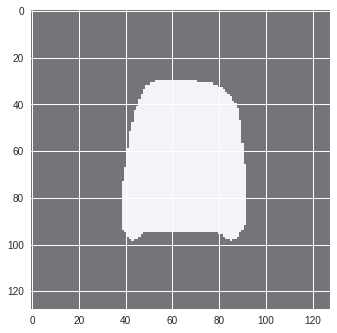

In [23]:
# checking the segmentation quality
# converting gray img to rgb
def gray2rgb(img):
  new_img =[]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      new_img.append(list(img[i][j])*3)
  new_img = np.array(new_img).reshape(img.shape[0] ,img.shape[1] ,3)
  return new_img
img = (out_x[1] >0.5)*1.0 # since the pixel give probaility ,so we taking only those whose value is greater than certain value
plt.imshow(gray2rgb(img) ,alpha =0.5)

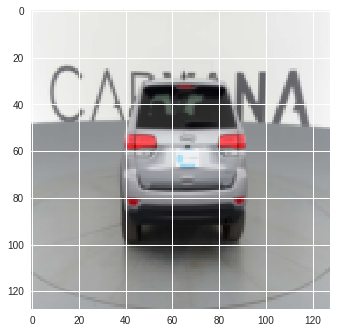

In [21]:
plt.imshow(val_x[1])

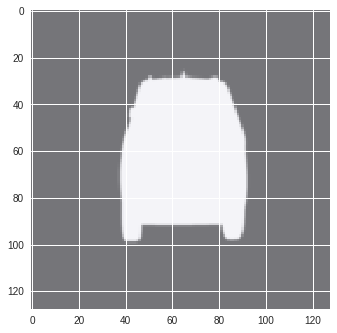

In [22]:
plt.imshow(gray2rgb(val_y[1]) ,alpha =0.5)

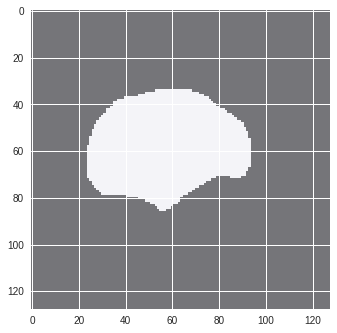

In [24]:
img = (out_x[20]>0.5) *1.0
plt.imshow(gray2rgb(img) ,alpha =0.5)         #segmented images

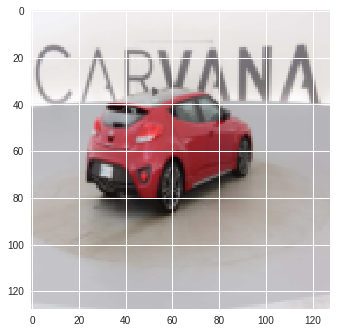

In [25]:
plt.imshow(val_x[20])            # input image

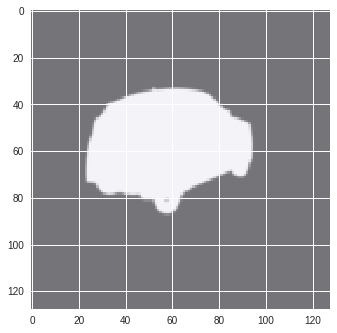

In [29]:
plt.imshow(gray2rgb(val_y[20]) ,alpha =0.5) # ground truth value